# Modeling Steps with Python

#### Note to Readers

For detailed explanations and insights related to the analyses and codes in this notebook, please refer to my Medium post. The post provides a comprehensive walkthrough of each step and concept in an easy-to-understand manner. It's an excellent resource to complement what you see here.

[Unlocking the Secrets of Financial Time Series: A Deep Dive into Autoregressive Models (AR)](https://medium.com/@lightpaper/unlocking-the-secrets-of-financial-time-series-a-deep-dive-into-autoregressive-models-ar-b2e58428928e)


## 0. Fetching Sample Data

In [24]:
import yfinance as yf
import pandas as pd

# Fetch WTI Crude Oil futures data
crude_oil_ticker = "CL=F"
crude_oil = yf.Ticker(crude_oil_ticker)
oil_data = crude_oil.history(period="1y", interval="1d")

# Prepare the 'Close' price data for analysis
oil_Close = oil_data['Close']
oil_Close.index = pd.to_datetime(oil_Close.index)
oil_Close_resampled = oil_Close.resample('D').mean().interpolate(method='linear')

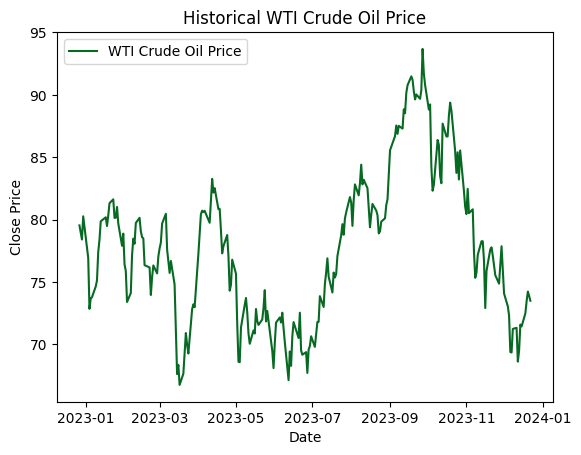

In [2]:
import matplotlib.pyplot as plt

plt.plot(oil_Close_resampled, label='WTI Crude Oil Price',color = '#076A23')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical WTI Crude Oil Price')
plt.legend()
plt.show()

## 1. Checking for Stationarity

In [3]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Fetch WTI Crude Oil futures data
crude_oil_ticker = "CL=F"
crude_oil = yf.Ticker(crude_oil_ticker)
oil_data = crude_oil.history(period="1y", interval="1d")

# Prepare the 'Close' price data for analysis
oil_Close = oil_data['Close']
oil_Close.index = pd.to_datetime(oil_Close.index)
oil_Close_resampled = oil_Close.resample('D').mean().interpolate(method='linear')

# Function to check stationarity of the time series
def check_stationarity(timeseries):
    result = adfuller(timeseries.values.flatten())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# Performing the ADF test on the resampled data
check_stationarity(oil_Close_resampled)



ADF Statistic: -2.204860
p-value: 0.204486


## 2. Making the Time Series Stationary

### Time Series Decomposition

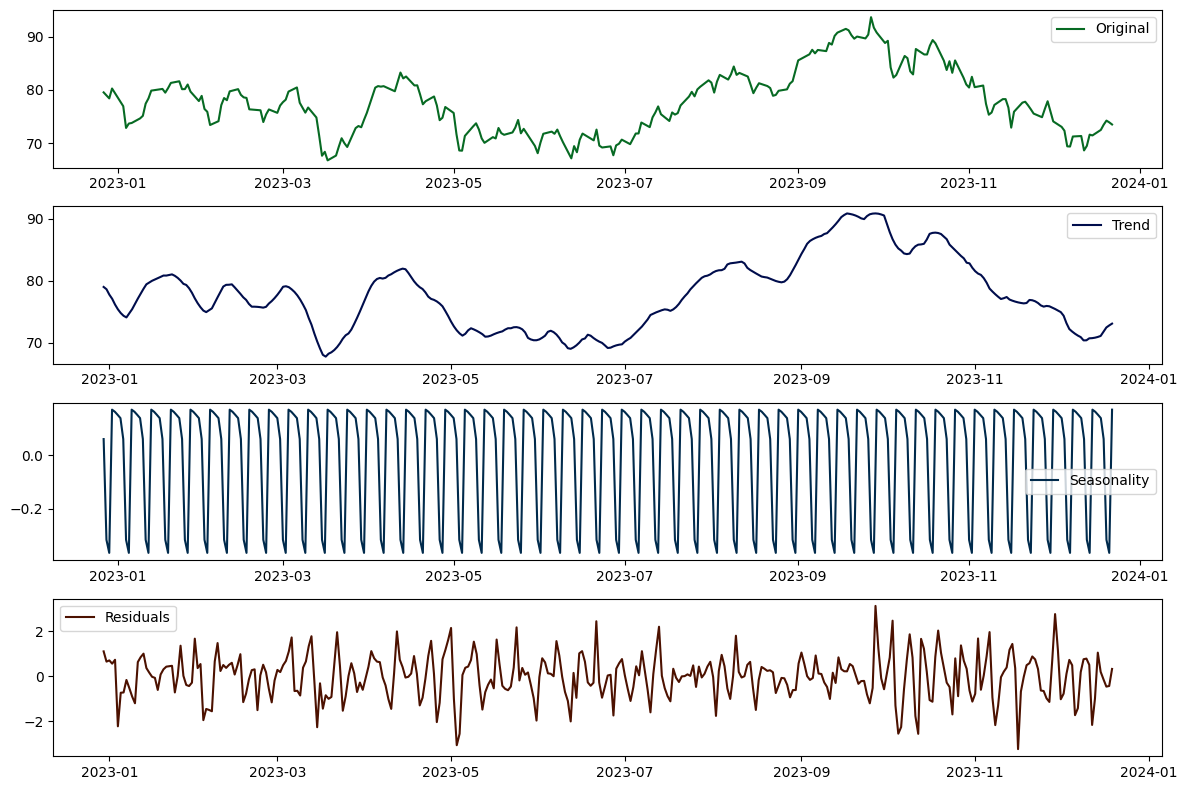

In [25]:
# Decomposing the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(oil_Close_resampled, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data and its components
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(oil_Close_resampled, label='Original', color='#076A23')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='#000D4C')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='#002A4C')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='#4C1100')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analyzing the Residuals

In [5]:
# Dropping NaN values in residuals
residual.dropna(inplace=True)

# Checking stationarity of residuals
check_stationarity(residual)

ADF Statistic: -8.125353
p-value: 0.000000


# 3. Identifying the Order of the AR Model

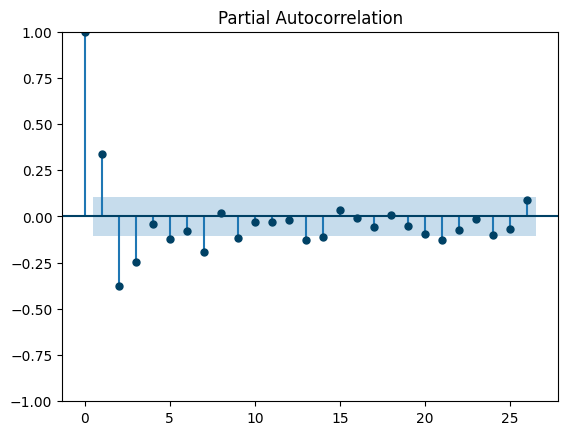

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(residual,color='#004165')
plt.show()

## 4. Estimating Model Parameters

In [7]:
from statsmodels.tsa.arima.model import ARIMA

p = 3  # Replace with identified order
model = ARIMA(residual, order=(p,0,0))
results = model.fit()

### Visualizing Residuals Predictions

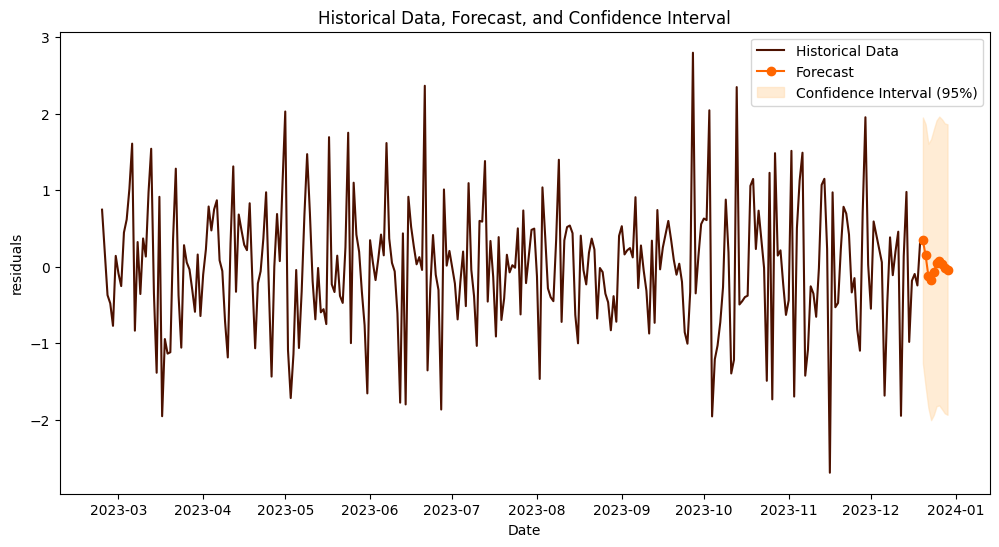

In [17]:

# Extracting residuals from the model
residuals = results.resid 

# Forecasting for forecast_steps
forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)

# Extracting the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)

# Plotting historical data, forecast points, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(residuals.index[-300:], residuals[-300:], label='Historical Data', color='#4C1100')
plt.plot(forecast_values.index, forecast_values, label='Forecast',color='#FF6600',marker='o')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='#FFDBAD', alpha=0.5, label='Confidence Interval (95%)')
plt.xlabel('Date')
plt.ylabel('residuals')
plt.title('Historical Data, Forecast, and Confidence Interval')
plt.legend()
plt.show()


## The Final Forecast of Original Oil Prices

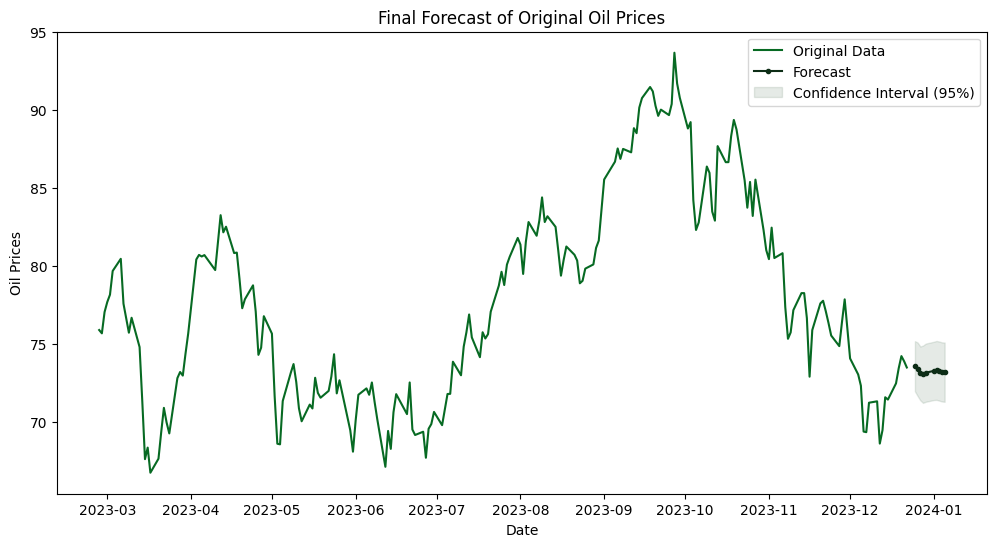

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# Fetch WTI Crude Oil futures data
last_date = oil_Close_resampled.index[-1]

# Create a date range for the next 10 business days
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq=BDay())[1:]

# Align forecasted values and confidence intervals with future dates
forecast_values.index = future_dates
confidence_intervals.index = future_dates

# Assuming trend and seasonal components are aligned with the original time series

future_trend = np.array([trend[-4]] * forecast_steps)  # or a more sophisticated extrapolation
future_seasonal = np.array([seasonal[-1]] * forecast_steps)  

# Combine the forecasts with the trend and seasonal components
final_forecast = forecast_values + future_trend + future_seasonal

# Adjust confidence intervals for the full time series
lower_bound = confidence_intervals.iloc[:, 0] + future_trend + future_seasonal
upper_bound = confidence_intervals.iloc[:, 1] + future_trend + future_seasonal

# Plotting the final forecast along with the original time series and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(oil_Close_resampled.index[-300:], oil_Close_resampled[-300:], label='Original Data', color='#076A23')
plt.plot(future_dates, final_forecast, label='Forecast', color='#0D2D16', marker='.')
plt.fill_between(future_dates, lower_bound, upper_bound, color='#003910', alpha=0.1, label='Confidence Interval (95%)')
plt.xlabel('Date')
plt.ylabel('Oil Prices')
plt.title('Final Forecast of Original Oil Prices')
plt.legend()
plt.show()